 <img src='sonify-logo.png' alt='Sonify' title='Workshop of time-frequency analysis' width=70px align='left'/>

#  Time–frequency analysis and sonification of geophysical data

Wellcome to the first part of a series of workshops focusing on representation and analysis of geophysical data in the audio domain. We will focus on a holistic representation of geodata and, in particular, will be working with the representation of time series and color images in the audio domain, the process known as sonification. This approach is both a great illustration of time-frequency processing methods and a useful domain for data interpretation. 

## Introduction to Time-Frequency Analysis


Time-frequency analysis is essential in geophysical data processing, as it allows the examination of spectral content as it changes over time. Such an analysis is crucial for signals that are non-stationary, where frequency content varies temporally, which is common in geophysical data.

Fourier Transform is a standard tool for signal analysis, but it lacks time-localized frequency information. The Short-Time Fourier Transform (STFT) resolves this by segmenting the signal into smaller sections and applying the Fourier Transform to each segment, yielding a time-dependent frequency spectrum.

The STFT is given by:
\begin{equation} 
STFT\{x(t)\}(\tau, \omega) = \int_{-\infty}^{+\infty} x(t) · w(t-\tau) · e^{-j\omega t} dt
\end{equation}

where $x(t) $ is the signal, $ w(t) $ is the window function, and $\tau$ and $\omega$ represent time and frequency, respectively.

The Hamming window, a commonly used window function, is defined as:
\begin{equation} 
w(n) = 0.54 - 0.46 \cos\left(\frac{2πn}{N-1}\right)
\end{equation}

for $ 0 \le n \le N-1 $, where $ N $ is the window length.

Wavelet transform is another method offering variable window size, thus providing better resolution in both time and frequency domains. This is especially useful for signals with transient features or rapid changes.

Time-frequency analysis has diverse applications in geophysics, including seismic, electromagnetic, and others. It enables pattern identification, anomaly detection, and a deeper understanding of complex signal behaviors, which are crucial for interpretation in exploration and monitoring.

In this workshop, we will apply STFT to identify instantaneous (within the window) frequencies of the signal which can be converted to MIDI notes, saved as an audio files and played as sound track - the process called "sonification". This approach was found to be useful, openning a new domain of data interpretation. The method is described in [this paper](https://onlinelibrary.wiley.com/doi/full/10.1111/1365-2478.12402)  


## Import data

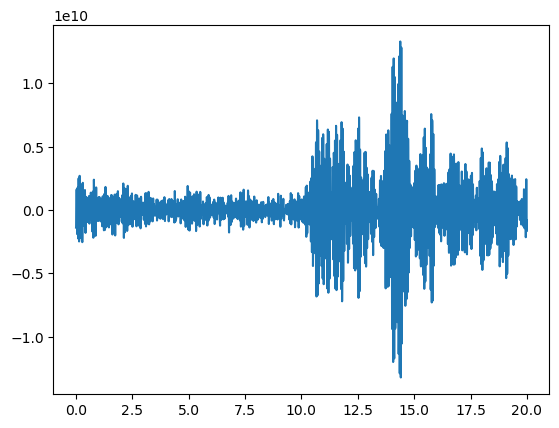

In [1]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt 
# Load the data from a .mat file
data = loadmat('s101ch1.mat')  # Make sure to include the .mat extension

# Extract time vector and data vector
t = data['D']['t'][0,0].flatten()  
X = data['D']['d'][0,0][:, 0]   

# Calculate time interval and sampling frequency
dt = t[1] - t[0]
Fs = 1 / dt

plt.plot(t,X)
plt.show()

## Data Processing

We first apply bandbass filtering to the seismic trace to extract useful signal and remove noise. After that, we apply STFT in a window moving through the time. Then, we identify the frequency corresponding to the maximum value of the 2D amplitude spectrum at each time slice using the smoothed amplitude spectrum. 

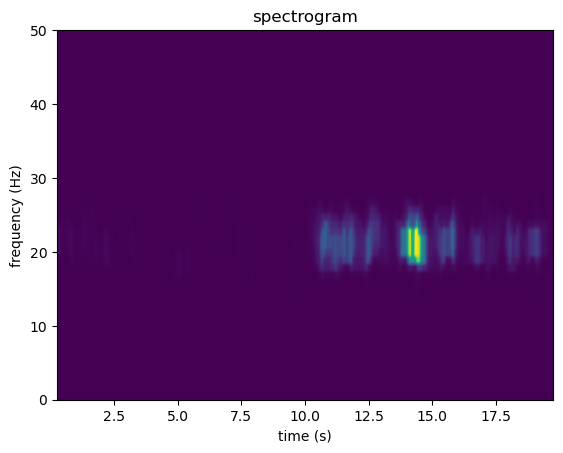

In [2]:
import numpy as np
from scipy.signal import butter, filtfilt, spectrogram
from scipy.ndimage import median_filter

# Bandpass filtering to remove noise
freq_min = 4  # Low frequency for filtering 
freq_max = 40  # High frequency for filtering 
f_Nyquist = Fs / 2  # Nyquist frequency - maximum frequency that can be measured

# Setup Butterworth filter
B, A = butter(6, [freq_min / f_Nyquist, freq_max / f_Nyquist], btype='band')

# Apply filter (make sure that it's zero phase - no shifts of signal)
# Also, handle NaN values by ignoring them in mean calculation
X_filtered = filtfilt(B, A, X - np.nanmean(X))
# Note, filtfilt applies the filter forward and backward, 
# ensuring a zero-phase response, which is important for 
# signal analysis where phase information is crucial.
X_filtered = X_filtered / np.max(np.abs(X_filtered))  # Normalize signal to 1

# Compute the spectrogram using the short-time Fourier transform
window = 128  # Window length for STFT
noverlap = 120  # Overlap between windows in STFT
nfft = 256  # Number of DFT points

# Compute the spectrogram using the short-time Fourier transform
# The signal is divided into segments "window" with "noverlap" points overlap,
# and each segment is windowed with a Hamming window.
# "nfft" is the number of frequency points used to calculate the discrete Fourier transform
frequencies, times, Sxx = spectrogram(X_filtered, fs=Fs, window='hamming', nperseg=window, noverlap=noverlap, nfft=nfft)

# Get amplitude spectrum and smooth the spectrogram using a median filter
Sxx = median_filter(np.abs(Sxx), size=(7, 7))

# Find the peak frequency in each time slice
peak_indices = np.argmax(Sxx, axis=0)
peak_frequencies = frequencies[peak_indices]  # Find peak frequency for each time slice

plt.imshow(Sxx, aspect='auto',origin='lower', extent=[times.min(), times.max(), frequencies.min(), frequencies.max()])
plt.xlabel('time (s)')
plt.ylabel('frequency (Hz)')
plt.title('spectrogram')
plt.ylim([0, 50])
plt.show()

## Convert frequencies to MIDI note numbers

We first calculate the MIDI note numbers from the peak_frequencies array using the [formula](https://en.wikipedia.org/wiki/MIDI_tuning_standard), which converts frequency in Hertz to a MIDI note number. We use a scaliing coefficient to convert seismic frequency to audiable signal. MIDI note numbers are integer numbers. We use np.ceil to round up to the nearest whole number and then cast the result to integers with .astype(int). The same type casting is done for the loudness to ensure MIDI compatibility. The loudness is calculated by finding the maximum amplitude of the spectrogram at each time slice, normalizing it against the highest amplitude in the entire spectrogram, and scaling it to fit into the MIDI velocity range, which is 0 to 127.

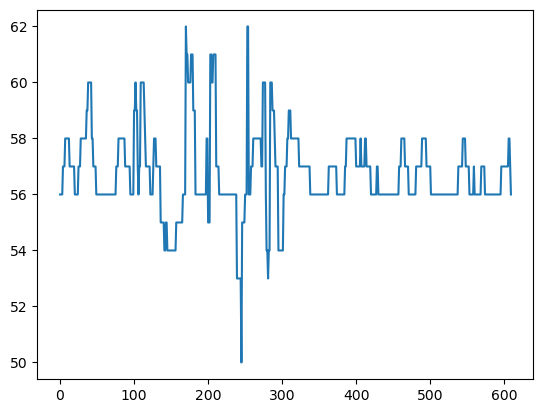

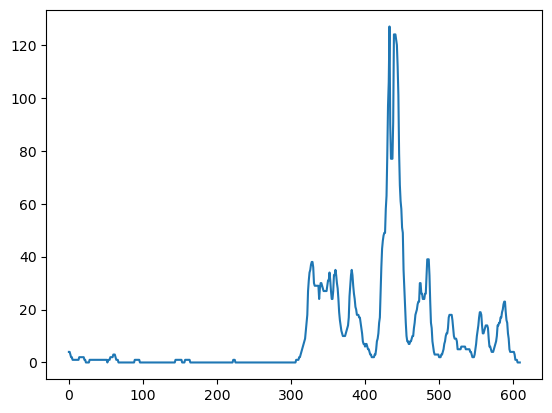

In [7]:
import numpy as np

# Scaling frequency coefficient to get audible signal 
FreqCoeff = 20

# Calculate MIDI notes from the peak frequencies
midi_notes = np.ceil(58 + 12 * np.log2(FreqCoeff * peak_frequencies / 440)).astype(int)

plt.figure
plt.plot(midi_notes)
plt.show()

# Initialize matrix:
N = len(midi_notes)  # Number of notes

# Calculate the loudness ('velocity') of the signal normalized in range 0 to 127
# The velocity is proportional to the maximum amplitude of the spectrogram
loudness = (127 * np.max(np.abs(Sxx), axis=0) / np.max(np.abs(Sxx))).astype(int)

plt.figure
plt.plot(loudness)
plt.show()

## Make a MIDI structure and write audio file on disk

To create a MIDI file, you'll need the mido library, which is a Python library for working with MIDI messages and files. If you don't have it installed, you can install it via 'conda install -c conda-forge mido'. This script will create a MIDI file where each note starts every 0.1 seconds (controlled by time_step) and lasts for 0.15 seconds (150 milliseconds).
We first initialize a MIDI file (MidiFile) and a MIDI track (MidiTrack), then iterate over the number of notes (N), and for each note:
- Create a 'note on' message with the calculated MIDI note number and loudness.
- Create a corresponding 'note off' message with a time difference to determine the note duration.
- Append these messages to the track.
- Save the track to a MIDI file ('AudioSeismogram-1.mid').

The time parameter in mido is a delta time, representing the time since the last message, in milliseconds. 

In [4]:
import mido
from mido import MidiFile, MidiTrack, Message, MAX_PITCHWHEEL
import sys
# Number of notes
N = len(midi_notes)
# Initialize MIDI track with note messages
mid = MidiFile()
track = MidiTrack()
mid.tracks.append(track)
ticks_per_expr = 20
# Time step in seconds for the notes (start time for each note)
time_step = 100
track.append(Message('program_change', program=10))
# Adding notes to the MIDI track
for i in range(N):
    track.append(Message('note_on', note=midi_notes[i].astype(int), velocity=loudness[i], time=time_step))
    for j in range(time_step // ticks_per_expr):
        pitch = MAX_PITCHWHEEL * j * ticks_per_expr // time_step
        track.append(Message('pitchwheel', pitch=pitch, time=ticks_per_expr))
    track.append(Message('note_off', note=midi_notes[i].astype(int), velocity=loudness[i], time=0))
# Write MIDI file to disk
mid.save('AudioSeismogram-1.mid')

##  Plot and play sonified seismic trace (animation currently working only in MATLAB)

- Define a function midi_to_audio that uses pretty_midi to convert MIDI data to an audio waveform.
- Play the converted audio using sounddevice.
- Create a figure window and plots the data, instantaneous spectrum, and sound amplitude in a loop.
- Update the plots with a vertical line that moves across the plot to indicate the current time point.
- Use plt.pause(0.02) to give an illusion of animation as it progresses through the loop.



In [6]:
import sounddevice as sd
import pretty_midi


midi_data = pretty_midi.PrettyMIDI('AudioSeismogram-1.mid')
audio_data = midi_data.synthesize(fs=Fs * FreqCoeff)

# Play the audio
sd.play(audio_data, Fs * FreqCoeff)

(0.0, 20.0)

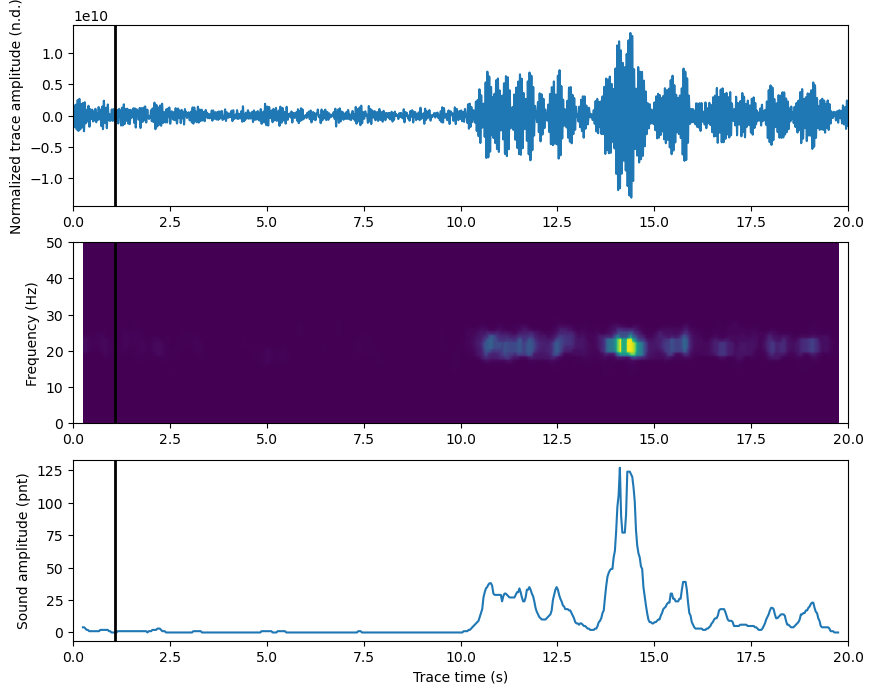

In [17]:
# Create and maximize figure window
plt.figure(figsize=(10, 8))

# Iterating through each note
# for it in range(N):
# Plot the signal
plt.subplot(3, 1, 1)
plt.plot(t, X)
plt.axvline(x=times[it], color='k', linewidth=2)
plt.ylabel('Normalized trace amplitude (n.d.)')
plt.xlim([0,20])
# Instantaneous spectrum plot
plt.subplot(3, 1, 2)
plt.imshow(abs(Sxx), aspect='auto', origin='lower', extent=[times.min(), times.max(), frequencies.min(), frequencies.max()])
plt.axvline(x=times[it], color='k', linewidth=2)
plt.ylim([0, 50])
plt.ylabel('Frequency (Hz)')
plt.xlim([0,20])
# Plot sound amplitude
plt.subplot(3, 1, 3)
plt.plot(times, loudness)
plt.axvline(x=times[it], color='k', linewidth=2)
plt.xlabel('Trace time (s)')
plt.ylabel('Sound amplitude (pnt)')
plt.xlim([0,20])
# Draw and pause
#plt.draw()
#plt.pause(0.02)

# Clear the figure for the next iteration
#plt.clf()

# Stop audio playback
sd.stop()

## Conclusions

In this example, we converted to sound a seismic trace extracted from an ocean bottom seismic record. The following steps are required:
- Data import to get a time series 
- Pre-processing to extract useful signal
- Calculate 2-D time-frequency spectrum using a Short-Time Fourier Transform (or other method of Time-Frequency analysis)
- Extract instantaneous peak frequency for each time slice using the time-frequency spectrum
- Convert instantaneous frequencies to MIDI notes
- Create MIDI structure and export and *.mid* file
- Create audio-synchronized animation and analyse the relation between the signal and its sonic representation. 